In [1]:
#@title Code Lines with Header Styling
from IPython.display import display,HTML
from IPython.core.magic import register_line_magic
@register_line_magic
def cmap_header(params):
    params=params.split('|'); string=params[0]
    if len(params)==1: 
        font_size='20'; font_family='Ewert'; cmap='Sinebow'
    elif  len(params)==2: 
        font_size=params[1]; font_family='Ewert'; cmap='Sinebow'
    elif  len(params)==3: 
        font_size=params[1]; font_family=params[2]; cmap='Sinebow'
    else: 
        font_size=params[1]; font_family=params[2]; cmap=params[3]
    html_str="""
    <head><script src='https://d3js.org/d3.v6.min.js'></script></head>
    <style>@import 'https://fonts.googleapis.com/css?family="""+\
    font_family+"""&effect=3d'; #colorized {font-family:"""+font_family+"""; 
    color:white; padding-left:10px; font-size:"""+font_size+"""px;}</style>
    <h1 id='colorized' class='font-effect-3d'>"""+string+"""</h1>
    <script>
    var tc=setInterval(function(){
        var now=new Date().getTime();
        var iddoc=document.getElementById('colorized');
        iddoc.style.color=d3.interpolate"""+cmap+"""(now%(60000)/60000);},1)
    </script>"""
    display(HTML(html_str))

In [2]:
%cmap_header CODE MODULES & HELPFUL TOOLS

In [3]:
import tensorflow as tf,os,math,numpy as np
from tensorflow.keras import layers as tkl
from tensorflow.keras import callbacks as tkc
from tensorflow.keras.preprocessing.image import \
load_img,array_to_img,img_to_array
from tensorflow.keras.preprocessing import \
image_dataset_from_directory
from IPython.display import display
import pylab as pl,PIL
from mpl_toolkits.axes_grid1.inset_locator import \
zoomed_inset_axes,mark_inset

In [4]:
%cmap_header DATA LOADING

In [5]:
dataset_url='http://www.eecs.berkeley.edu/Research/'+\
            'Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz'
data_dir=tf.keras.utils.get_file(
    origin=dataset_url,fname='BSR',untar=True)
root_dir=os.path.join(data_dir,'BSDS500/data')
data_path=os.path.join(root_dir,'images')
test_path=os.path.join(data_path,'test')
test_paths=sorted(
    [os.path.join(test_path,fname) 
    for fname in os.listdir(test_path)
    if fname.endswith('.jpg')])
test_paths[:3]

['/root/.keras/datasets/BSR/BSDS500/data/images/test/100007.jpg',
 '/root/.keras/datasets/BSR/BSDS500/data/images/test/100039.jpg',
 '/root/.keras/datasets/BSR/BSDS500/data/images/test/100099.jpg']

In [6]:
%cmap_header DATA PROCESSING

In [7]:
def scale01(img): return img/255
def process_input(input_rgb,img_size):
    input_yuv=tf.image.rgb_to_yuv(input_rgb)
    last_dimension_axis=len(input_yuv.shape)-1
    y,u,v=tf.split(input_yuv,3,axis=last_dimension_axis)
    return tf.image.resize(y,[img_size,img_size],method='area')
def process_target(input_rgb):
    input_yuv=tf.image.rgb_to_yuv(input_rgb)
    last_dimension_axis=len(input_yuv.shape)-1
    y,u,v=tf.split(input_yuv,3,axis=last_dimension_axis)
    return y  

Found 500 files belonging to 2 classes.
Using 400 files for training.
Found 500 files belonging to 2 classes.
Using 100 files for validation.


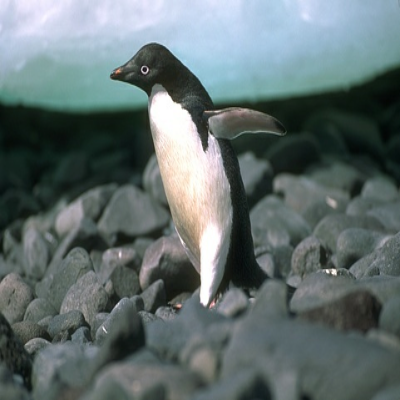

In [8]:
[crop_size,upscale_factor]=[400,4]
input_size=crop_size//upscale_factor
batch_size=8
train_ds=image_dataset_from_directory(
    root_dir,batch_size=batch_size,
    image_size=(crop_size,crop_size),
    validation_split=.2,subset='training',
    seed=123,label_mode=None,)
valid_ds=image_dataset_from_directory(
    root_dir,batch_size=batch_size,
    image_size=(crop_size,crop_size),
    validation_split=.2,subset='validation',
    seed=123,label_mode=None,)
train_ds=train_ds.map(scale01)
valid_ds=valid_ds.map(scale01)
for batch in train_ds.take(1):
    for img in batch: display(array_to_img(img)); break

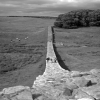

==> ==> ==> ==> ==> ==> ==> ==> ==> ==> 


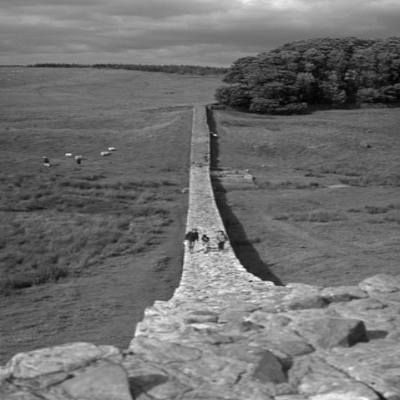

In [9]:
train_ds=train_ds.map(
    lambda x:(process_input(x,input_size),process_target(x)))
train_ds=train_ds.prefetch(buffer_size=16)
valid_ds=valid_ds.map(
    lambda x:(process_input(x,input_size),process_target(x)))
valid_ds=valid_ds.prefetch(buffer_size=16)
for batch in valid_ds.take(1):
    for img in batch[0]: display(array_to_img(img)); break
    print(10*'==> ')
    for img in batch[1]: display(array_to_img(img)); break

In [10]:
%cmap_header MODEL BUILDING

In [11]:
def model(upscale_factor=upscale_factor,channels=1):
    conv_args={'activation':'relu',
               'kernel_initializer':'Orthogonal',
               'padding':'same',}
    inputs=tf.keras.Input(shape=(None,None,channels))
 #   x=tkl.Conv2D(1024,5,**conv_args)(inputs)
    x=tkl.Conv2D(512,5,**conv_args)(inputs)
    x=tkl.Conv2D(256,5,**conv_args)(x)
    x=tkl.Conv2D(96,5,**conv_args)(x)
    x=tkl.Conv2D(32,3,**conv_args)(x)
    x=tkl.Conv2D(channels*(upscale_factor**2),3,**conv_args)(x)
    outputs=tf.nn.depth_to_space(x,upscale_factor)
    return tf.keras.Model(inputs,outputs)

In [12]:
%cmap_header CALLBACKS & PLOTTING

In [13]:
def display_results(img,prefix,title):
    img_array=img_to_array(img)
    img_array=img_array.astype('float32')/255
    fig,ax=pl.subplots()
    im=ax.imshow(img_array[::-1],origin='lower')
    pl.title(title)
    axins=zoomed_inset_axes(ax,2,loc=5)
    axins.imshow(img_array[::-1],origin='lower')
    x1,x2,y1,y2=200,300,100,200
    axins.set_xlim(x1,x2); axins.set_ylim(y1,y2)
    pl.yticks(visible=False); pl.xticks(visible=False)
    mark_inset(ax,axins,loc1=2,loc2=3,fc='none',ec='magenta')
    pl.savefig(str(prefix)+'_'+title+'.png')
    pl.show()
def low_resolution_img(img,upscale_factor):
    dimensions=(img.size[0]//upscale_factor,
                img.size[1]//upscale_factor)
    return img.resize(dimensions,PIL.Image.BICUBIC)
def upscale_img(model,img):
    ycbcr=img.convert('YCbCr')
    y,cb,cr=ycbcr.split()
    y=img_to_array(y).astype('float32')/255
    input_img=np.expand_dims(y,axis=0)
    out=model.predict(input_img)
    out_img_y=out[0]*255.
    out_img_y=out_img_y.clip(0,255)
    out_img_y=out_img_y.reshape(
        (np.shape(out_img_y)[0],np.shape(out_img_y)[1]))
    out_img_y=PIL.Image.fromarray(np.uint8(out_img_y),mode='L')
    out_img_cb=cb.resize(out_img_y.size,PIL.Image.BICUBIC)
    out_img_cr=cr.resize(out_img_y.size,PIL.Image.BICUBIC)
    out_img=PIL.Image.merge(
        'YCbCr',(out_img_y,out_img_cb,out_img_cr))
    return out_img.convert('RGB')

In [14]:
class ESPCNCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback,self).__init__()
        self.test_img=low_resolution_img(
            load_img(test_paths[0]),upscale_factor)
    def on_epoch_begin(self,epoch,logs=None):
        self.psnr=[]
    def on_epoch_end(self,epoch,logs=None):
        print('mean PSNR for epoch: %.2f'%(np.mean(self.psnr)))
        if epoch%25==0:
            prediction=upscale_img(self.model,self.test_img)
            display_results(
                prediction,'epoch-'+str(epoch),'prediction')
    def on_test_batch_end(self,batch,logs=None):
        self.psnr.append(10*math.log10(1/logs['loss']))

In [15]:
early_stopping=tkc.EarlyStopping(monitor='loss',patience=10)
checkpoint_path='/tmp/checkpoint'
checkpoint=tkc.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    monitor='loss',mode='min',save_best_only=True,verbose=2)
lr_reduction=tkc.ReduceLROnPlateau(
    monitor='val_loss',patience=10,verbose=2,factor=.9)

In [16]:
%cmap_header MODEL COMPILING & TRAINING

In [17]:
model=model(upscale_factor=upscale_factor,channels=1)
model.summary()
callbacks=[ESPCNCallback(),early_stopping,checkpoint,lr_reduction]
loss_fn=tf.keras.losses.MeanSquaredError()
optimizer=tf.keras.optimizers.Adam(learning_rate=.001)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 512)   13312     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 256)   3277056   
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 96)    614496    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 32)    27680     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 16)    4624      
_________________________________________________________________
tf.nn.depth_to_space (TFOpLa (None, None, None, 1)     0     

Epoch 1/200
50/50 - 14s - loss: 0.0856 - val_loss: 0.0111
mean PSNR for epoch: 19.74


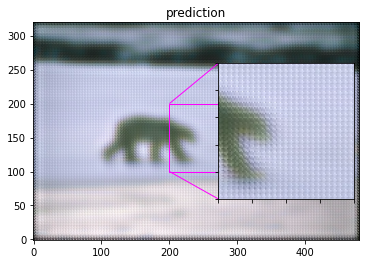


Epoch 00001: loss improved from inf to 0.08555, saving model to /tmp/checkpoint
Epoch 2/200
50/50 - 9s - loss: 0.0077 - val_loss: 0.0066
mean PSNR for epoch: 21.95

Epoch 00002: loss improved from 0.08555 to 0.00769, saving model to /tmp/checkpoint
Epoch 3/200
50/50 - 9s - loss: 0.0066 - val_loss: 0.0084
mean PSNR for epoch: 20.83

Epoch 00003: loss improved from 0.00769 to 0.00656, saving model to /tmp/checkpoint
Epoch 4/200
50/50 - 9s - loss: 0.0077 - val_loss: 0.0046
mean PSNR for epoch: 23.38

Epoch 00004: loss did not improve from 0.00656
Epoch 5/200
50/50 - 9s - loss: 0.0039 - val_loss: 0.0040
mean PSNR for epoch: 23.80

Epoch 00005: loss improved from 0.00656 to 0.00385, saving model to /tmp/checkpoint
Epoch 6/200
50/50 - 9s - loss: 0.0035 - val_loss: 0.0037
mean PSNR for epoch: 24.29

Epoch 00006: loss improved from 0.00385 to 0.00349, saving model to /tmp/checkpoint
Epoch 7/200
50/50 - 9s - loss: 0.0033 - val_loss: 0.0035
mean PSNR for epoch: 24.72

Epoch 00007: loss improved

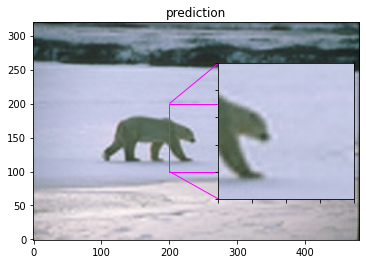


Epoch 00026: loss did not improve from 0.00256
Epoch 27/200
50/50 - 9s - loss: 0.0026 - val_loss: 0.0028
mean PSNR for epoch: 25.40

Epoch 00027: loss did not improve from 0.00256
Epoch 28/200
50/50 - 9s - loss: 0.0025 - val_loss: 0.0029
mean PSNR for epoch: 25.39

Epoch 00028: loss improved from 0.00256 to 0.00255, saving model to /tmp/checkpoint

Epoch 00028: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.
Epoch 29/200
50/50 - 9s - loss: 0.0025 - val_loss: 0.0028
mean PSNR for epoch: 25.26

Epoch 00029: loss improved from 0.00255 to 0.00252, saving model to /tmp/checkpoint
Epoch 30/200
50/50 - 9s - loss: 0.0025 - val_loss: 0.0028
mean PSNR for epoch: 25.42

Epoch 00030: loss did not improve from 0.00252
Epoch 31/200
50/50 - 9s - loss: 0.0040 - val_loss: 0.0048
mean PSNR for epoch: 23.26

Epoch 00031: loss did not improve from 0.00252
Epoch 32/200
50/50 - 9s - loss: 0.0036 - val_loss: 0.0030
mean PSNR for epoch: 25.27

Epoch 00032: loss did not improve from 0.00252

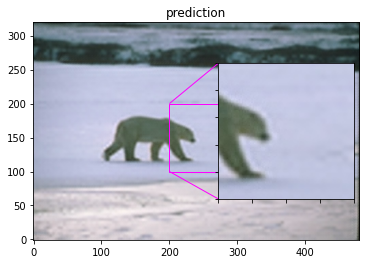


Epoch 00051: loss did not improve from 0.00246
Epoch 52/200
50/50 - 9s - loss: 0.0025 - val_loss: 0.0028
mean PSNR for epoch: 25.50

Epoch 00052: loss did not improve from 0.00246
Epoch 53/200
50/50 - 9s - loss: 0.0025 - val_loss: 0.0028
mean PSNR for epoch: 25.70

Epoch 00053: loss improved from 0.00246 to 0.00246, saving model to /tmp/checkpoint
Epoch 54/200
50/50 - 9s - loss: 0.0025 - val_loss: 0.0028
mean PSNR for epoch: 25.80

Epoch 00054: loss improved from 0.00246 to 0.00245, saving model to /tmp/checkpoint
Epoch 55/200
50/50 - 9s - loss: 0.0025 - val_loss: 0.0028
mean PSNR for epoch: 25.74

Epoch 00055: loss did not improve from 0.00245
Epoch 56/200
50/50 - 9s - loss: 0.0025 - val_loss: 0.0030
mean PSNR for epoch: 25.28

Epoch 00056: loss did not improve from 0.00245
Epoch 57/200
50/50 - 9s - loss: 0.0025 - val_loss: 0.0028
mean PSNR for epoch: 25.50

Epoch 00057: loss did not improve from 0.00245
Epoch 58/200
50/50 - 9s - loss: 0.0025 - val_loss: 0.0027
mean PSNR for epoch: 2

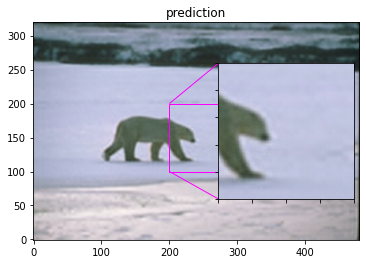


Epoch 00076: loss did not improve from 0.00240
Epoch 77/200
50/50 - 9s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 25.55

Epoch 00077: loss improved from 0.00240 to 0.00240, saving model to /tmp/checkpoint
Epoch 78/200
50/50 - 9s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 25.70

Epoch 00078: loss improved from 0.00240 to 0.00240, saving model to /tmp/checkpoint
Epoch 79/200
50/50 - 9s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 25.30

Epoch 00079: loss improved from 0.00240 to 0.00239, saving model to /tmp/checkpoint

Epoch 00079: ReduceLROnPlateau reducing learning rate to 0.0005314410547725857.
Epoch 80/200
50/50 - 9s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 25.59

Epoch 00080: loss improved from 0.00239 to 0.00239, saving model to /tmp/checkpoint
Epoch 81/200
50/50 - 9s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 25.83

Epoch 00081: loss did not improve from 0.00239
Epoch 82/200
50/50 - 9s - loss: 0.0024 - val_loss: 0.0027


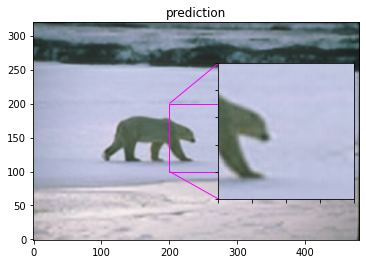


Epoch 00101: loss improved from 0.00236 to 0.00236, saving model to /tmp/checkpoint
Epoch 102/200
50/50 - 9s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 25.47

Epoch 00102: loss did not improve from 0.00236
Epoch 103/200
50/50 - 9s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 25.89

Epoch 00103: loss did not improve from 0.00236
Epoch 104/200
50/50 - 9s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 25.16

Epoch 00104: loss did not improve from 0.00236
Epoch 105/200
50/50 - 9s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 25.96

Epoch 00105: loss did not improve from 0.00236
Epoch 106/200
50/50 - 9s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 25.51

Epoch 00106: loss did not improve from 0.00236
Epoch 107/200
50/50 - 9s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 25.76

Epoch 00107: loss improved from 0.00236 to 0.00235, saving model to /tmp/checkpoint
Epoch 108/200
50/50 - 9s - loss: 0.0023 - val_loss: 0.0027
mean PSNR for e

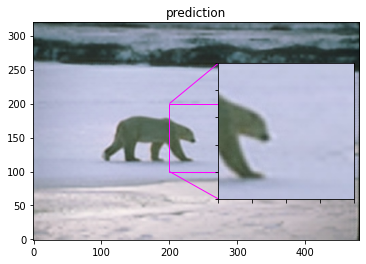


Epoch 00126: loss improved from 0.00233 to 0.00233, saving model to /tmp/checkpoint
Epoch 127/200
50/50 - 9s - loss: 0.0023 - val_loss: 0.0027
mean PSNR for epoch: 25.74

Epoch 00127: loss did not improve from 0.00233
Epoch 128/200
50/50 - 9s - loss: 0.0023 - val_loss: 0.0027
mean PSNR for epoch: 25.51

Epoch 00128: loss did not improve from 0.00233
Epoch 129/200
50/50 - 9s - loss: 0.0023 - val_loss: 0.0027
mean PSNR for epoch: 25.69

Epoch 00129: loss improved from 0.00233 to 0.00232, saving model to /tmp/checkpoint

Epoch 00129: ReduceLROnPlateau reducing learning rate to 0.00031381062290165574.
Epoch 130/200
50/50 - 9s - loss: 0.0023 - val_loss: 0.0027
mean PSNR for epoch: 25.62

Epoch 00130: loss did not improve from 0.00232
Epoch 131/200
50/50 - 9s - loss: 0.0023 - val_loss: 0.0027
mean PSNR for epoch: 25.82

Epoch 00131: loss improved from 0.00232 to 0.00232, saving model to /tmp/checkpoint
Epoch 132/200
50/50 - 9s - loss: 0.0023 - val_loss: 0.0027
mean PSNR for epoch: 25.76

Ep

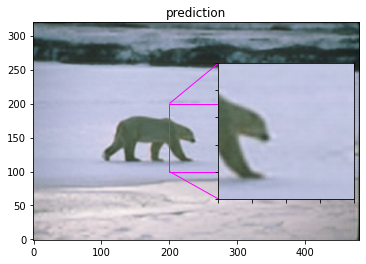


Epoch 00151: loss improved from 0.00230 to 0.00230, saving model to /tmp/checkpoint

Epoch 00151: ReduceLROnPlateau reducing learning rate to 0.00025418660952709616.
Epoch 152/200
50/50 - 9s - loss: 0.0023 - val_loss: 0.0027
mean PSNR for epoch: 25.70

Epoch 00152: loss improved from 0.00230 to 0.00230, saving model to /tmp/checkpoint
Epoch 153/200
50/50 - 9s - loss: 0.0023 - val_loss: 0.0027
mean PSNR for epoch: 25.63

Epoch 00153: loss improved from 0.00230 to 0.00230, saving model to /tmp/checkpoint
Epoch 154/200
50/50 - 9s - loss: 0.0023 - val_loss: 0.0027
mean PSNR for epoch: 26.04

Epoch 00154: loss improved from 0.00230 to 0.00229, saving model to /tmp/checkpoint
Epoch 155/200
50/50 - 9s - loss: 0.0023 - val_loss: 0.0027
mean PSNR for epoch: 25.79

Epoch 00155: loss did not improve from 0.00229
Epoch 156/200
50/50 - 9s - loss: 0.0023 - val_loss: 0.0027
mean PSNR for epoch: 25.74

Epoch 00156: loss improved from 0.00229 to 0.00229, saving model to /tmp/checkpoint
Epoch 157/200
5

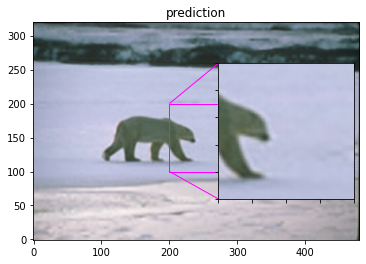


Epoch 00176: loss did not improve from 0.00228
Epoch 177/200
50/50 - 9s - loss: 0.0023 - val_loss: 0.0027
mean PSNR for epoch: 25.87

Epoch 00177: loss improved from 0.00228 to 0.00228, saving model to /tmp/checkpoint
Epoch 178/200
50/50 - 9s - loss: 0.0023 - val_loss: 0.0027
mean PSNR for epoch: 26.32

Epoch 00178: loss did not improve from 0.00228
Epoch 179/200
50/50 - 9s - loss: 0.0023 - val_loss: 0.0027
mean PSNR for epoch: 25.93

Epoch 00179: loss improved from 0.00228 to 0.00227, saving model to /tmp/checkpoint
Epoch 180/200
50/50 - 9s - loss: 0.0023 - val_loss: 0.0027
mean PSNR for epoch: 25.43

Epoch 00180: loss did not improve from 0.00227
Epoch 181/200
50/50 - 9s - loss: 0.0023 - val_loss: 0.0027
mean PSNR for epoch: 25.65

Epoch 00181: loss improved from 0.00227 to 0.00227, saving model to /tmp/checkpoint

Epoch 00181: ReduceLROnPlateau reducing learning rate to 0.00018530203378759326.
Epoch 182/200
50/50 - 9s - loss: 0.0023 - val_loss: 0.0027
mean PSNR for epoch: 25.66

Ep

In [18]:
epochs=200
model.compile(optimizer=optimizer,loss=loss_fn,)
history=model.fit(
    train_ds,epochs=epochs,callbacks=callbacks,
    validation_data=valid_ds,verbose=2)
model.load_weights(checkpoint_path)

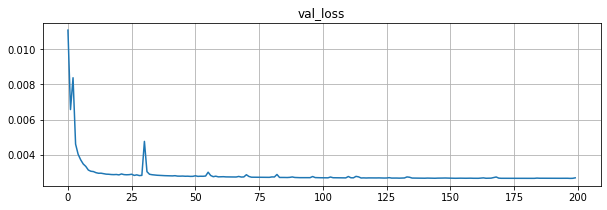

In [19]:
history_keys=list(history.history.keys())
pl.figure(figsize=(10,3))
pl.plot(history.history[history_keys[1]])
pl.grid(); pl.title(history_keys[1]);

In [20]:
%cmap_header TEST RESULTS

PSNR of low resolution and high resolution is 21.9522
PSNR of predict and high resolution is 22.5655


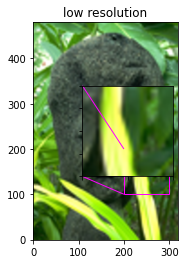

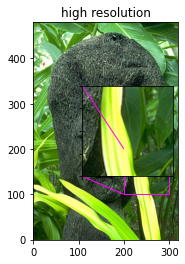

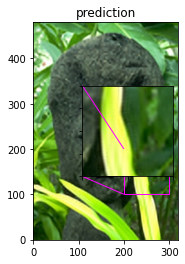

PSNR of low resolution and high resolution is 20.5894
PSNR of predict and high resolution is 20.9442


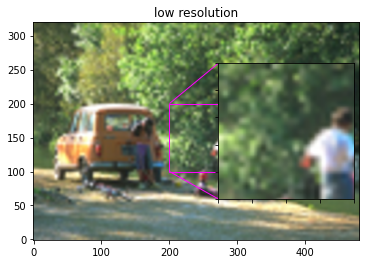

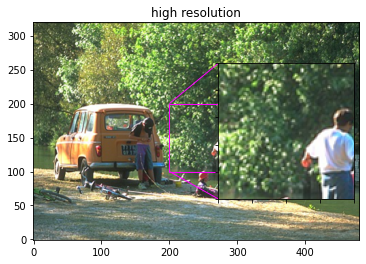

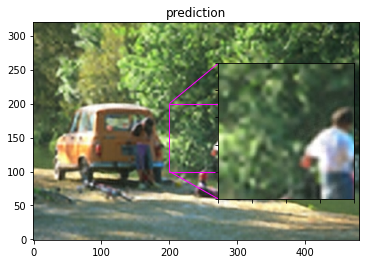

PSNR of low resolution and high resolution is 22.6938
PSNR of predict and high resolution is 23.3883


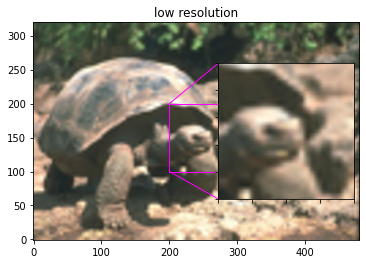

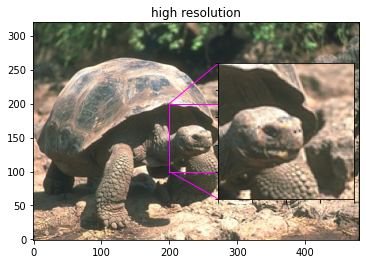

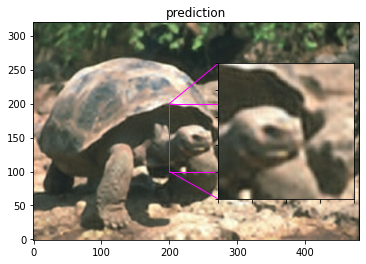

PSNR of low resolution and high resolution is 32.0279
PSNR of predict and high resolution is 32.9002


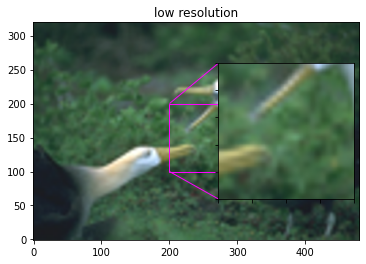

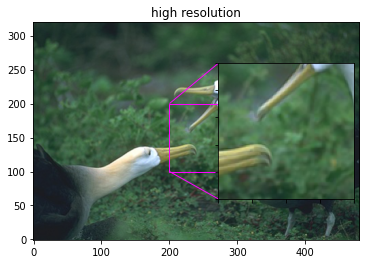

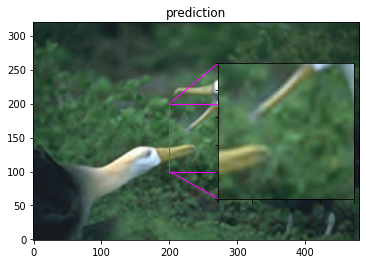

PSNR of low resolution and high resolution is 25.4892
PSNR of predict and high resolution is 26.1356


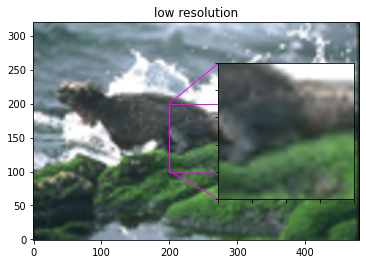

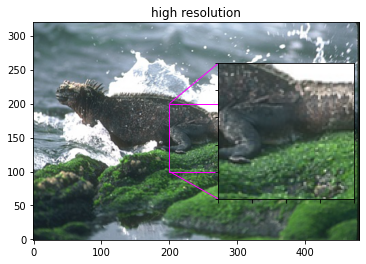

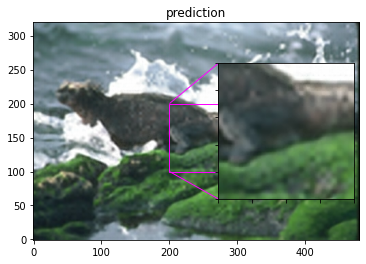

PSNR of low resolution and high resolution is 26.6017
PSNR of predict and high resolution is 27.0360


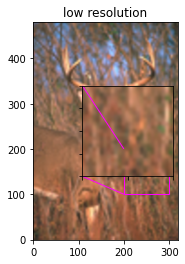

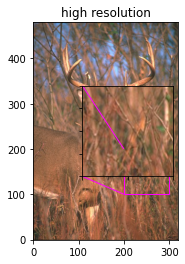

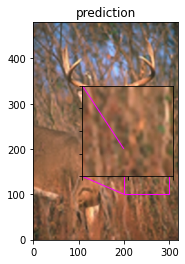

PSNR of low resolution and high resolution is 30.3825
PSNR of predict and high resolution is 30.6285


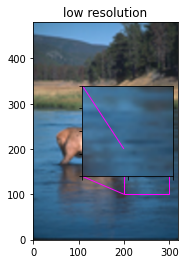

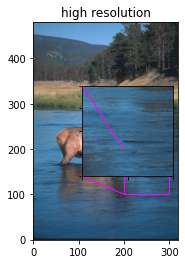

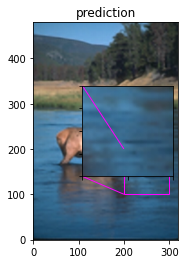

PSNR of low resolution and high resolution is 27.5683
PSNR of predict and high resolution is 27.9922


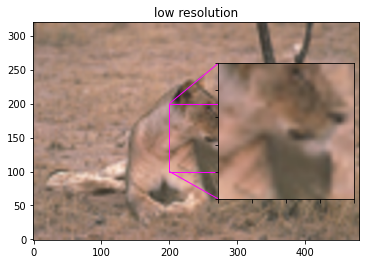

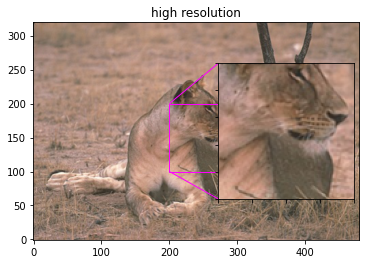

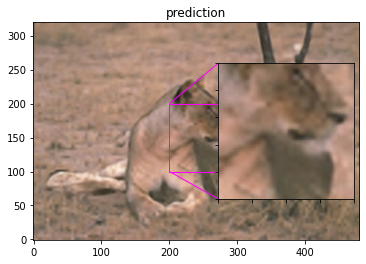

PSNR of low resolution and high resolution is 31.4097
PSNR of predict and high resolution is 32.1944


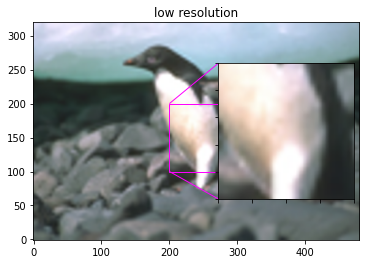

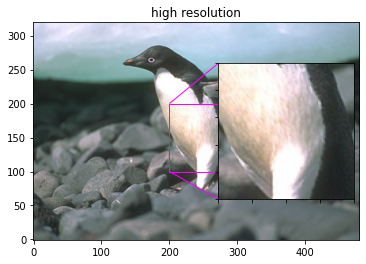

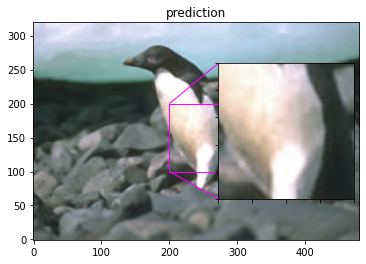

PSNR of low resolution and high resolution is 29.9933
PSNR of predict and high resolution is 30.7770


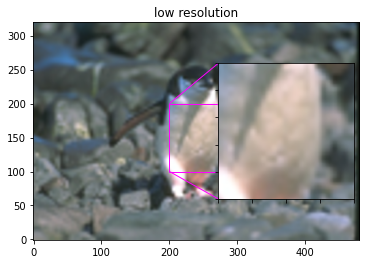

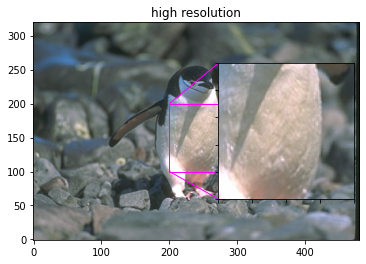

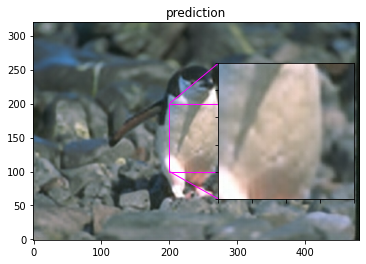

avg. PSNR of images with low resolution is 26.8708
avg. PSNR of reconstructions is 27.4562


In [21]:
total_bicubic_psnr=0.; total_test_psnr=0.
for index,test_path in enumerate(test_paths[5:15]):
    img=load_img(test_path)
    lowres_input=low_resolution_img(img,upscale_factor)
    w=lowres_input.size[0]*upscale_factor
    h=lowres_input.size[1]*upscale_factor
    highres_img=img.resize((w,h))
    predict_img=upscale_img(model,lowres_input)
    lowres_img=lowres_input.resize((w,h))
    lowres_img_arr=img_to_array(lowres_img)
    highres_img_arr=img_to_array(highres_img)
    predict_img_arr=img_to_array(predict_img)
    bicubic_psnr=tf.image.psnr(
        lowres_img_arr,highres_img_arr,max_val=255)
    test_psnr=tf.image.psnr(
        predict_img_arr,highres_img_arr,max_val=255)
    total_bicubic_psnr+=bicubic_psnr
    total_test_psnr+=test_psnr
    print('PSNR of low resolution '+\
          'and high resolution is %.4f'%bicubic_psnr)
    print('PSNR of predict and high resolution is %.4f'%test_psnr)
    display_results(lowres_img,index,'low resolution')
    display_results(highres_img,index,'high resolution')
    display_results(predict_img,index,'prediction')
print('avg. PSNR of images with low resolution is %.4f'\
      %(total_bicubic_psnr/10))
print('avg. PSNR of reconstructions is %.4f'\
      %(total_test_psnr/10))